## 1. Data Load & Importing Libraries

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Ignore all warnings
warnings.simplefilter("ignore")

In [245]:
df = pd.read_csv('/content/online_shoppers_intention.csv')

## 2. Data Preprocessing

In [246]:
numerical_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                      'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues' , 'SpecialDay' , 'Weekend']
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']

In [247]:
# Check the balance of the target variable 'Revenue'
print("\nDistribution of the target variable 'Revenue':")
print(df['Revenue'].value_counts(normalize=True))


Distribution of the target variable 'Revenue':
Revenue
False    0.845255
True     0.154745
Name: proportion, dtype: float64


In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [249]:
df['Weekend'].replace({True: 1, False: 0}, inplace=True)

In [250]:
df.loc[:,['OperatingSystems', 'Browser', 'Region', 'TrafficType']] = df[['OperatingSystems', 'Browser', 'Region', 'TrafficType']].astype('int64').astype('object')

In [251]:
# We get rid of duplicated data
df.drop_duplicates(inplace=True, keep='first')
df.duplicated().sum(), df.shape

(0, (12205, 18))

## 3. Exploratory Data Analysis

### EDA - Univariate Analysis

In [252]:
print(numerical_features)
print("\n")
print(categorical_features)

['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend']


['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']


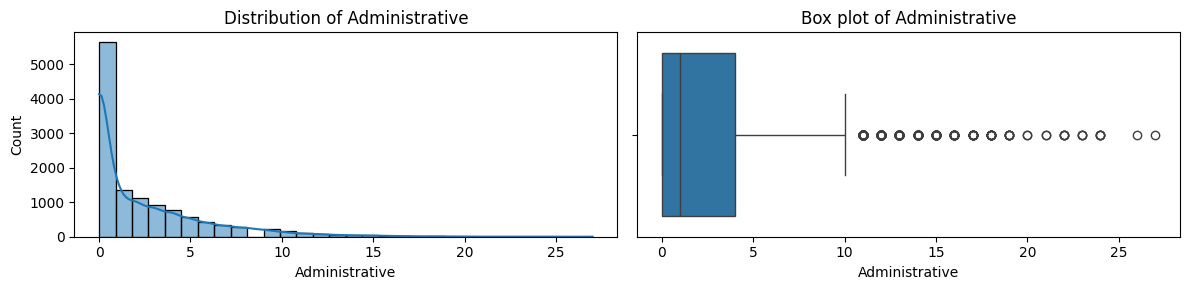

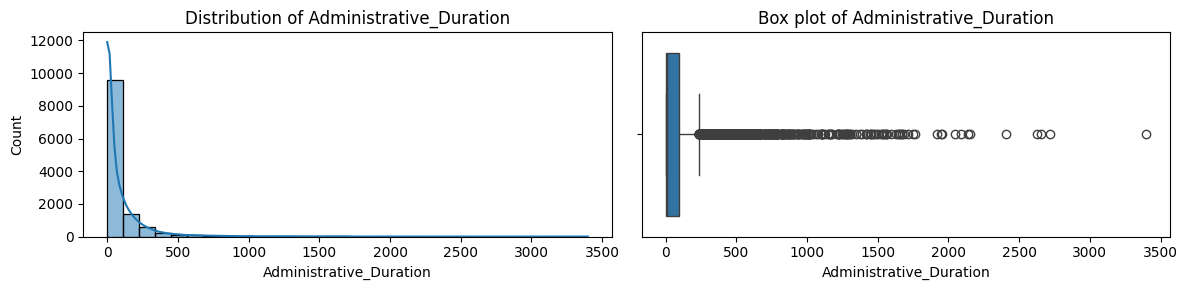

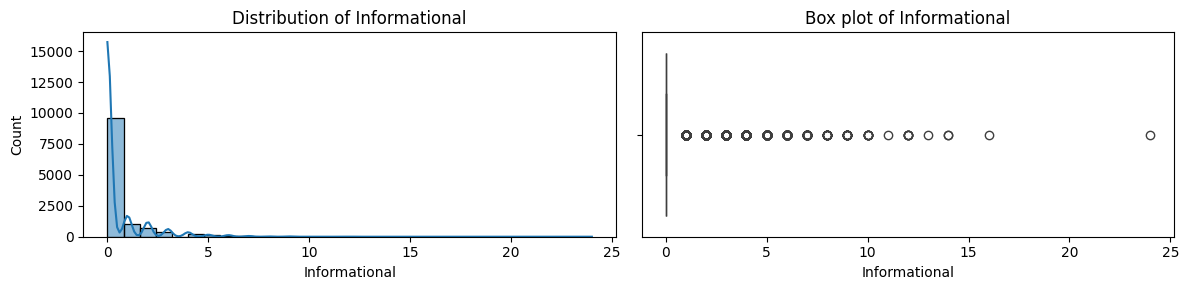

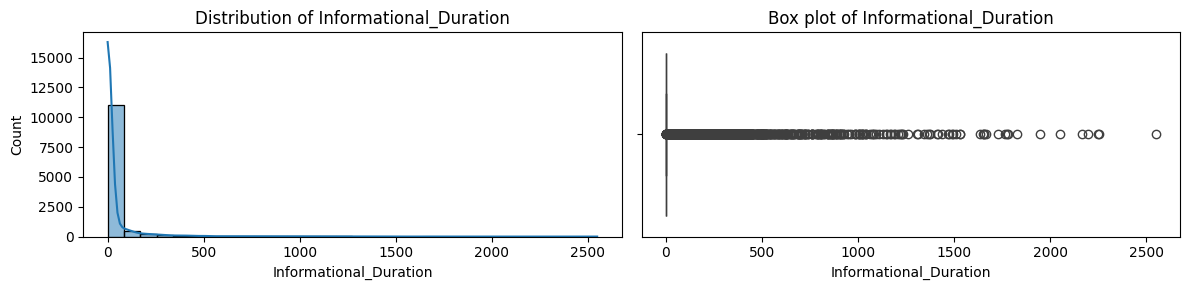

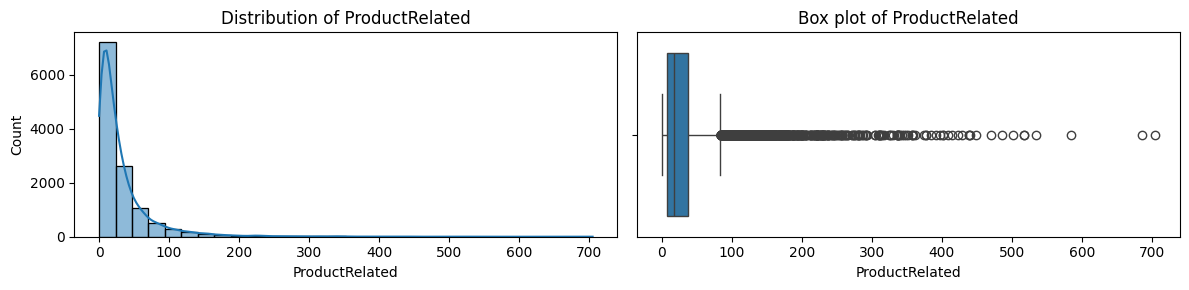

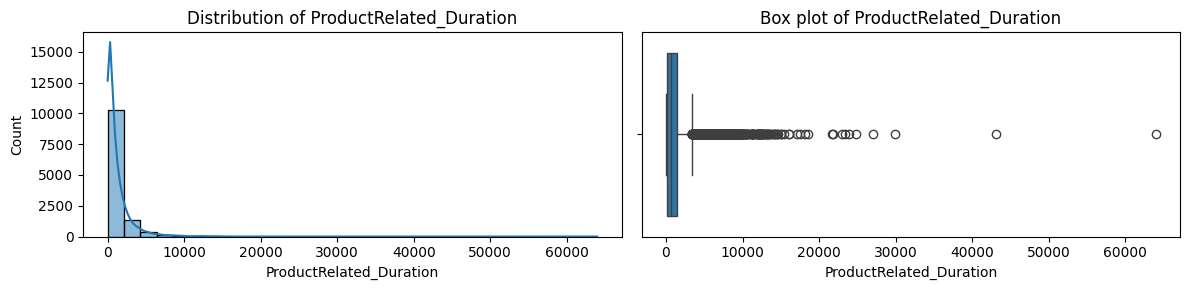

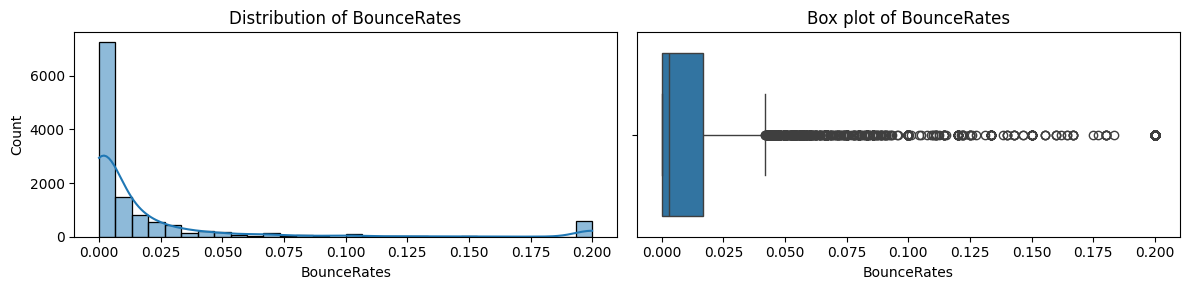

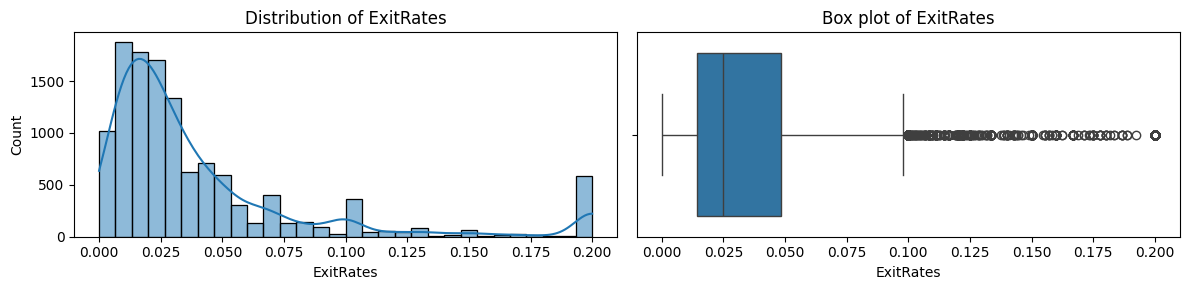

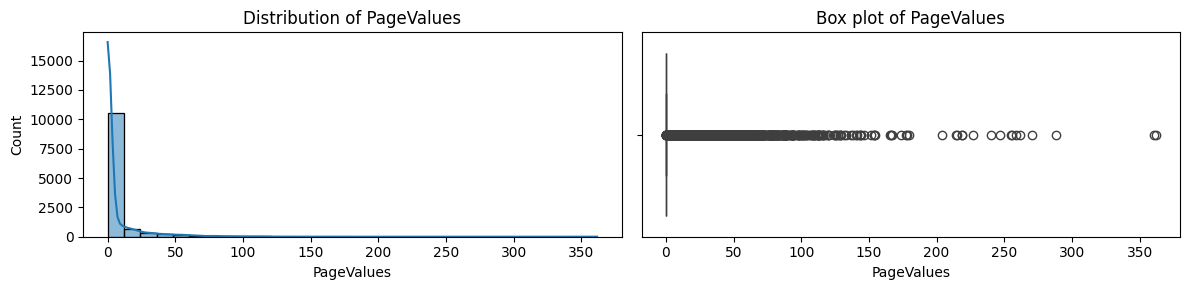

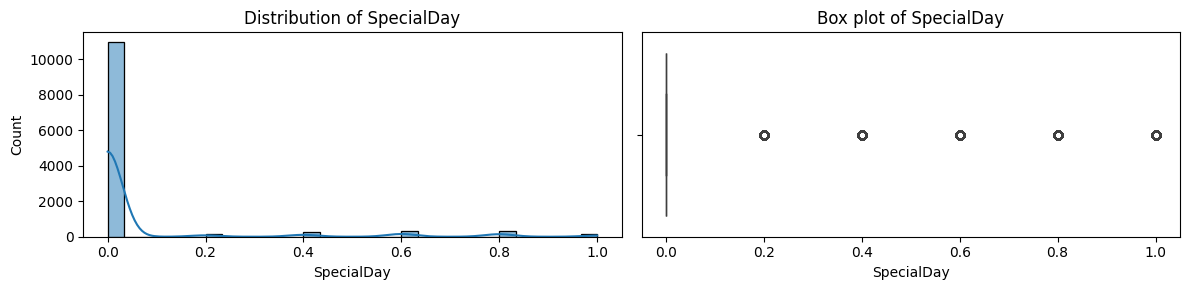

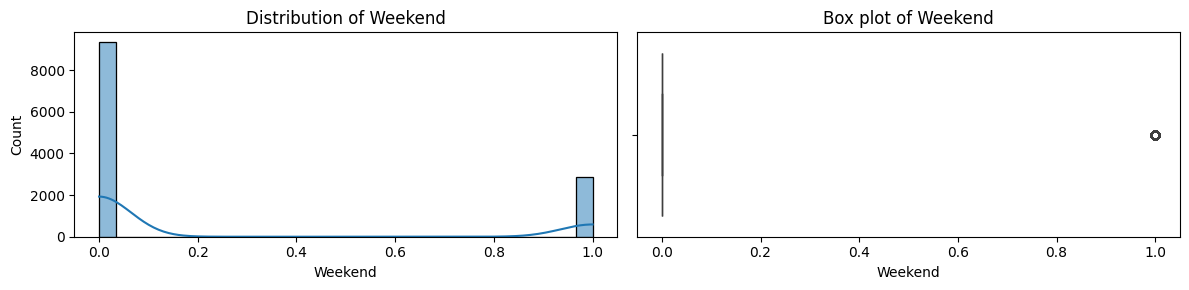

In [253]:
# Univariate Analysis - Numerical Features

# Plotting histplot and boxplot in one row for each numerical feature
for feature in numerical_features:
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))

    # Histplot on the left
    sns.histplot(df[feature], kde=True, ax=axs[0], bins = 30)
    axs[0].set_title(f'Distribution of {feature}')

    # Boxplot on the right
    sns.boxplot(x=df[feature], ax=axs[1])
    axs[1].set_title(f'Box plot of {feature}')

    plt.tight_layout()
    plt.show()

<Axes: xlabel='OperatingSystems'>

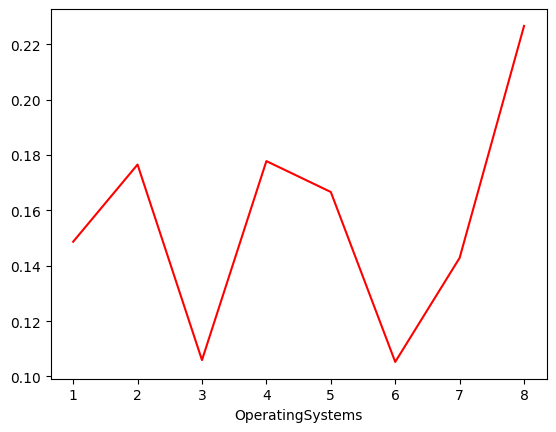

In [254]:
# @title Average Visitors by Operating Systems

df.groupby('OperatingSystems')['Revenue'].mean().plot(kind='line', color='red')

### EDA - Bi-Variate Analysis

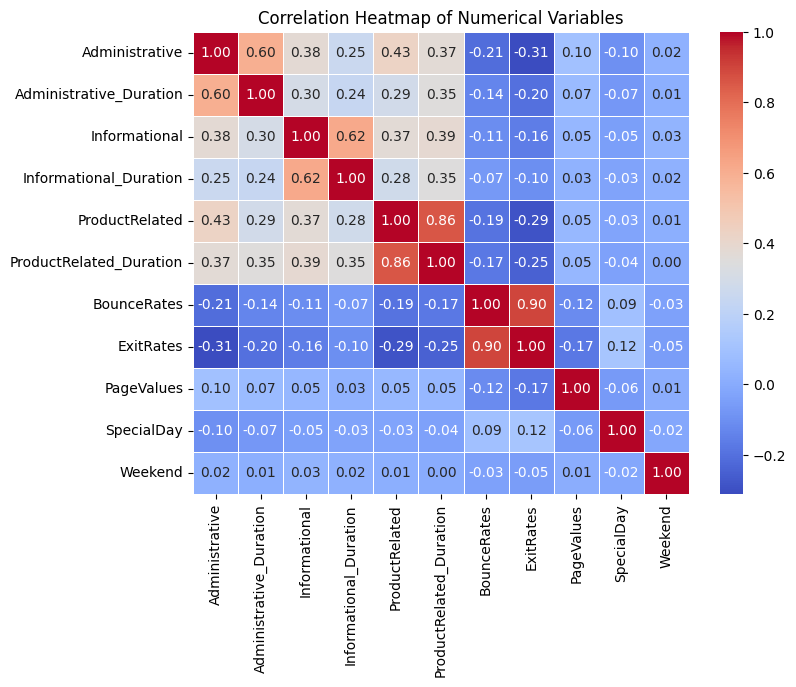

In [255]:
# Compute the correlation matrix
corr = df[numerical_features].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

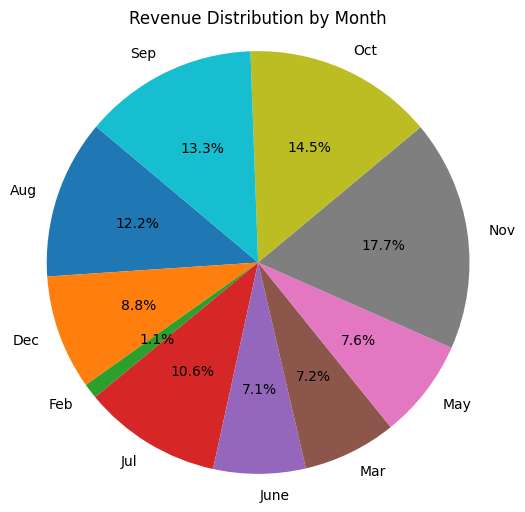

In [256]:
import matplotlib.pyplot as plt

# Calculate the total revenue for each month
revenue_by_month = df.groupby('Month')['Revenue'].mean()

# Plotting
plt.figure(figsize=(6, 6))
plt.pie(revenue_by_month, labels=revenue_by_month.index, autopct='%1.1f%%', startangle=140)
plt.title('Revenue Distribution by Month')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

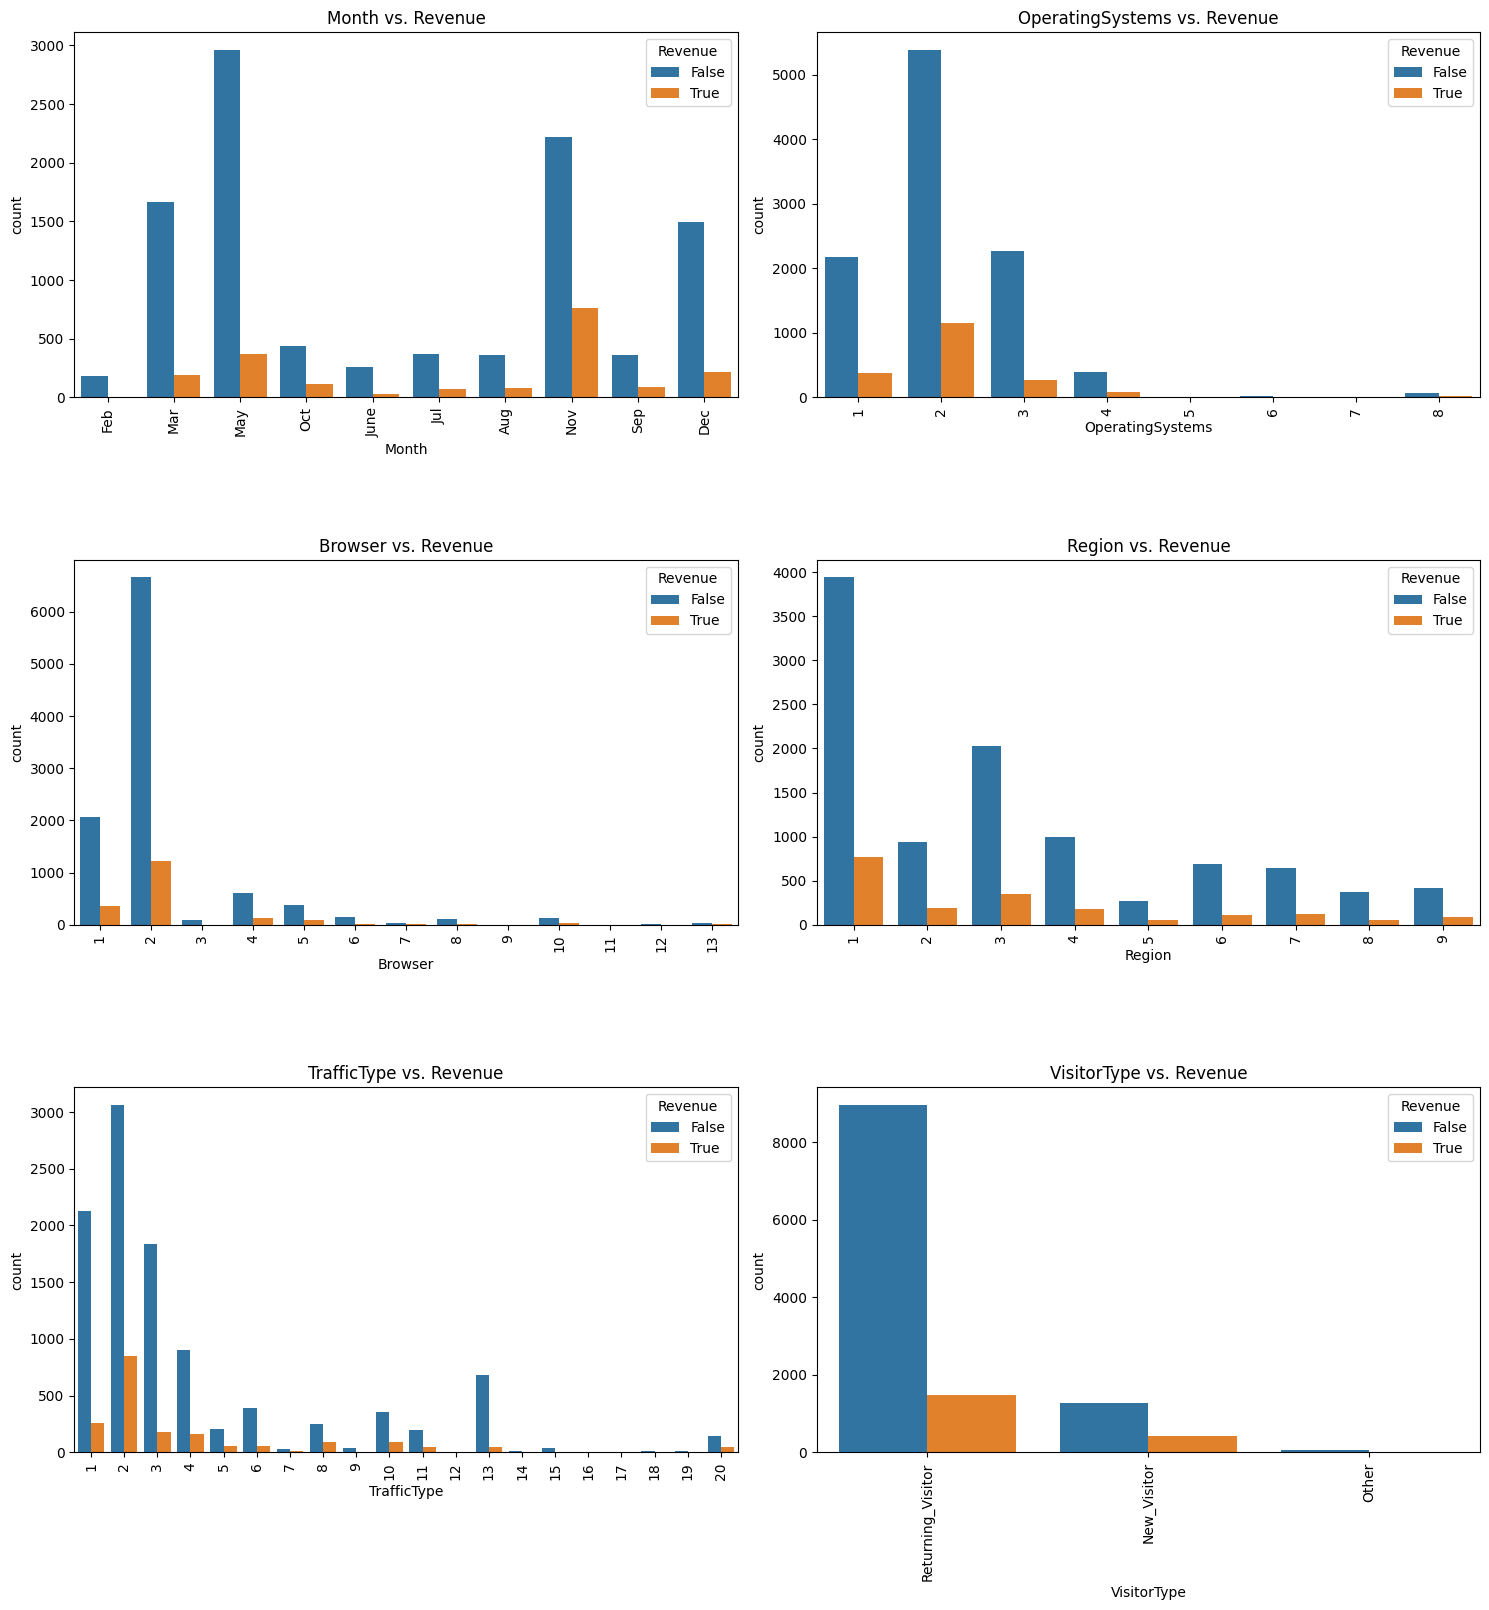

In [257]:
# Bivariate Analysis - Categorical Features vs. Revenue
plt.figure(figsize=(15, 20))
for i, feature in enumerate(categorical_features):
    plt.subplot(4, 2, i+1)
    sns.countplot(data=df, x=feature, hue='Revenue')
    plt.title(f'{feature} vs. Revenue')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Missing Value Treatment

In [258]:
# Handling missing values for numerical features
for feature in numerical_features:
    df[feature].fillna(df[feature].median(), inplace=True)  # Using median to fill missing values

# Handling missing values for categorical features
for feature in categorical_features:
    df[feature].fillna(df[feature].mode()[0], inplace=True)  # Using mode to fill missing values

# Verify that there are no missing values left
print("\nMissing Values after Treatment:")
print(df.isnull().sum())


Missing Values after Treatment:
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


## Outlier Detection & Removal

In [259]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import boxcox

def handle_outliers(df, numerical_features, method, threshold):
    """
    Handle outliers in the dataset.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        numerical_features (list): List of numerical feature column names.
        method (str): Method for handling outliers ('remove', 'cap', or 'transform').
        threshold (float): Z-score threshold for defining outliers.

    Returns:
        pd.DataFrame: Dataframe after handling outliers.
    """
    # Ensure numerical features are numeric
    df[numerical_features] = df[numerical_features].apply(pd.to_numeric, errors='coerce')

    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(df[numerical_features], nan_policy='omit'))
    outliers = (z_scores > threshold)

    num_outliers = np.sum(outliers.any(axis=1))
    print(f"Number of identified outliers: {num_outliers}")

    if method == 'remove':
        # Option 1: Remove outliers
        df_clean = df[~(outliers.any(axis=1))]
        print(f"Removed {num_outliers} outliers. Original shape: {df.shape}, New shape: {df_clean.shape}")
        return df_clean

    elif method == 'cap':
        # Option 2: Cap outliers
        df_capped = df.copy()
        for feature in numerical_features:
            mean = df[feature].mean()
            std = df[feature].std()
            cap_value = mean + threshold * std
            df_capped[feature] = np.where(df_capped[feature] > cap_value, cap_value, df_capped[feature])
        print(f"Capped values for {num_outliers} outliers. Shape remains unchanged: {df_capped.shape}")
        return df_capped

    elif method == 'transform':
        # Option 3: Transform outliers (e.g., Box-Cox transformation)
        df_transformed = df.copy()
        for feature in numerical_features:
            # Handle non-positive values for Box-Cox transformation
            positive_values = df_transformed[feature] + 1 - df_transformed[feature].min()
            transformed_values, _ = boxcox(positive_values[positive_values > 0])
            # Fill transformed values back, using original column index positions
            df_transformed.loc[positive_values.index, feature] = transformed_values
        print(f"Transformed values for {num_outliers} outliers. Shape remains unchanged: {df_transformed.shape}")
        return df_transformed

    else:
        raise ValueError("Method must be one of 'remove', 'cap', or 'transform'.")


In [260]:
df = handle_outliers(df, numerical_features, method='transform', threshold=5)

Number of identified outliers: 431
Transformed values for 431 outliers. Shape remains unchanged: (12205, 18)


## Feature Engineering

### Feature Encoding

In [261]:
import numpy as np
import pandas as pd

def encode_month(df, month_column='Month'):
    """
    Encode the month column using sine and cosine transformation.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        month_column (str): The column name containing month data.

    Returns:
        pd.DataFrame: Dataframe with encoded month values and original month column removed.
    """
    # Assign a numerical value to each month
    month_to_num = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5,
        'June': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9,
        'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    # Map month names to numerical values
    df['month_num'] = df[month_column].map(month_to_num)

    # Encode with sine and cosine
    df['month_sin'] = np.sin((df['month_num'] - 1) * (2. * np.pi / 12))
    df['month_cos'] = np.cos((df['month_num'] - 1) * (2. * np.pi / 12))

    # Drop the original month column and the temporary numerical column
    df.drop(columns=[month_column, 'month_num'], inplace=True)

    print("Encoding for Month variable completed...")
    return df

df = encode_month(df, month_column='Month')


Encoding for Month variable completed...


In [262]:
# Function to one-hot encode 'VisitorType'
def one_hot_encode_visitor_type(df, column_name='VisitorType'):
    # Create one-hot encoded columns
    visitor_types = df[column_name].unique()
    for visitor_type in visitor_types:
        df[f'{column_name}_{visitor_type}'] = (df[column_name] == visitor_type).astype(int)

    # Drop the original 'VisitorType' column
    df.drop(columns=[column_name], inplace=True)
    print("One Hot Encoding completed for variable VisitorType...")
    return df

# Apply the one-hot encoding function
df = one_hot_encode_visitor_type(df)

One Hot Encoding completed for variable VisitorType...


In [263]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(df):
    """
    One-hot encode all categorical columns in the dataframe.

    Parameters:
        df (pd.DataFrame): The input dataframe.

    Returns:
        pd.DataFrame: Dataframe with one-hot encoded columns and original categorical columns removed.
    """
    encoder = OneHotEncoder(sparse_output=False)

    # Iterate through all categorical columns
    for col in df.select_dtypes(include='object'):
        # Fit and transform the column
        transformed = encoder.fit_transform(df[[col]])

        # Create a DataFrame from the encoded columns
        encoded_df = pd.DataFrame(transformed, columns=[f"{col}_{category}" for category in encoder.categories_[0]])

        # Add the new columns to the original DataFrame
        df = df.join(encoded_df.set_index(df.index))

    # Drop the original categorical columns
    df.drop(columns=df.select_dtypes(include='object').columns, inplace=True)

    print("One-hot encoding of remaining Categorical variables completed...")

    return df


df = one_hot_encode(df)


One-hot encoding of remaining Categorical variables completed...


In [264]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20
0,0.0,0.0,0.0,0.0,0.696503,0.000000,0.025562,0.044254,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.107058,6.938391,0.000000,0.039613,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.696503,0.000000,0.025562,0.044254,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.107058,1.509991,0.021784,0.042584,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.438376,14.545761,0.013786,0.029794,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Importance

In [265]:
from sklearn.ensemble import RandomForestClassifier

def calculate_feature_importance(df, target_column):
    """
    Calculate feature importance using RandomForestClassifier.

    Parameters:
        df (pd.DataFrame): Input dataframe containing features and target.
        target_column (str): The name of the target variable column.

    Returns:
        feature_importances (pd.DataFrame): DataFrame with feature names and their importance scores.
    """
    # Separate features (X) and target (y)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Initialize RandomForestClassifier
    model = RandomForestClassifier(random_state=42)

    # Fit the model
    model.fit(X, y)

    # Get feature importances
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    })

    # Sort features by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    print(f"Feature importance calculated for {len(X.columns)} features.")

    return feature_importances

In [266]:
# First, calculate the feature importance
feature_importances = calculate_feature_importance(df, target_column='Revenue')

Feature importance calculated for 66 features.


### Feature Selection

In [267]:
def select_top_features(df, feature_importances, target_column, top_percentage=0.8):
    """
    Select the top percentage of features based on importance and plot the top 10 features.

    Parameters:
        df (pd.DataFrame): Input dataframe containing features and target.
        feature_importances (pd.DataFrame): DataFrame with feature names and their importance scores.
        target_column (str): The name of the target variable column.
        top_percentage (float): Percentage of features to select based on importance.

    Returns:
        df_selected (pd.DataFrame): DataFrame with top selected features and target column.
    """
    # Determine the number of features to select
    num_features_to_select = int(top_percentage * len(feature_importances))

    # Select the top features based on importance
    selected_features = feature_importances['Feature'].head(num_features_to_select).tolist()

    # Create new DataFrame with selected features and the target column
    df_selected = df[selected_features + [target_column]]

    print(f"Selected top {top_percentage*100}% features, retaining {len(selected_features)} out of {len(feature_importances)} features.")

    # Plot top 10 features
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette='viridis')
    plt.title('Top 10 Important Features')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.show()

    return df_selected

Selected top 80.0% features, retaining 52 out of 66 features.


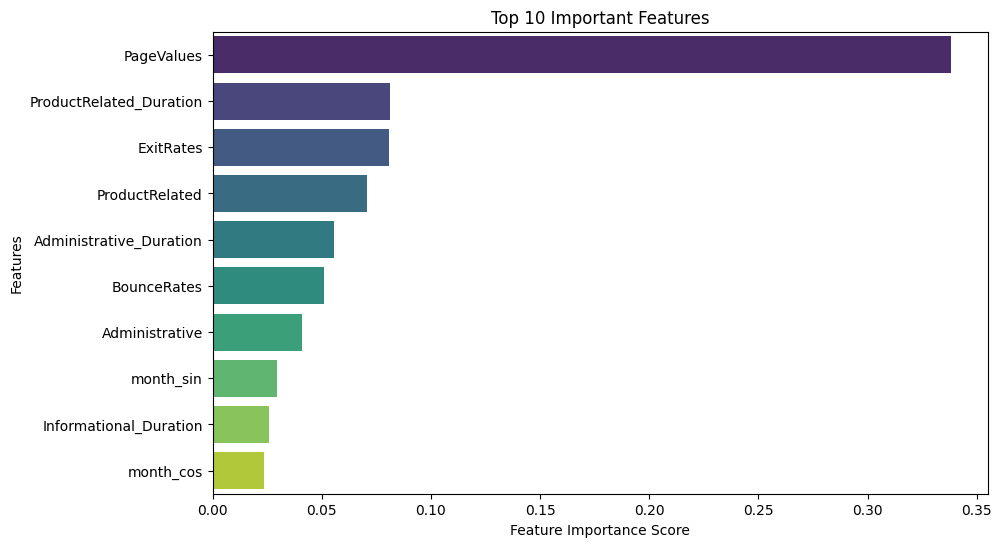

In [268]:
# Now, select the top 80% features and plot the top 10
df = select_top_features(df, feature_importances, target_column='Revenue')

In [269]:
df.shape

(12205, 53)

### Feature Scaling

In [270]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def scale_numerical_features_exclude_target(df, target_column):
    """
    Scale all numerical columns in the dataframe except for the target variable.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        target_column (str): The name of the target column to exclude from scaling.

    Returns:
        pd.DataFrame: Dataframe with scaled numerical columns, excluding the target variable.
    """
    scaler = StandardScaler()

    # Select numerical columns excluding the target column
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    numerical_cols = numerical_cols[numerical_cols != target_column]

    # Scale numerical columns
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    return df


df = scale_numerical_features_exclude_target(df, target_column='Revenue')


## Data Oversampling - SMOTE

In [271]:
import pandas as pd
from imblearn.over_sampling import SMOTE

def oversample_with_smote(df, target_column):
    """
    Perform data oversampling using the SMOTE technique.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        target_column (str): The name of the target column.

    Returns:
        pd.DataFrame: Dataframe with oversampled data.
        pd.Series: Series with oversampled target values.
    """
    # Separate features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Initialize SMOTE
    smote = SMOTE(random_state=42)

    # Fit and transform the data
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Create a new dataframe from the resampled data
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[target_column] = y_resampled

    return df_resampled, y_resampled

# Example usage
df_resampled, y_resampled = oversample_with_smote(df, target_column='Revenue')


In [272]:
df_resampled.shape

(20594, 53)

In [273]:
# Check the balance of the target variable 'Revenue'
print("\nDistribution of the target variable 'Revenue' in df_resampled:")
print(df_resampled['Revenue'].value_counts(normalize=True))


Distribution of the target variable 'Revenue' in df_resampled:
Revenue
False    0.5
True     0.5
Name: proportion, dtype: float64


In [274]:
df.shape

(12205, 53)

## Train Test Split

In [275]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_data(df, target_column, test_size=0.2, random_state=42):
    """
    Split the original dataframe into training and testing sets.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        target_column (str): The name of the target column.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Seed used by the random number generator.

    Returns:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.
    """
    # Separate features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test



In [276]:
# Separate features and target variable
X = df.drop(columns=['Revenue'])
y = df['Revenue']

# Perform train-test split
X_train, X_test, y_train, y_test = split_data(df, target_column='Revenue')


## Supporting Plot Functions

In [277]:
# Function to print metrics in a table-like format
def print_metrics_table(metrics):
    """
    Print the metrics for each model in a table-like format.

    Parameters:
        metrics (dict): Dictionary with model names as keys and evaluation metrics as values.
    """
    print(f"{'Model':<20} {'Accuracy':<10} {'AUC-ROC':<10} {'Recall':<10}")
    print("="*50)
    for model_name, scores in metrics.items():
        print(f"{model_name:<20} {scores['Accuracy']:<10.4f} {scores['AUC-ROC']:<10.4f} {scores['Recall']:<10.4f}")

In [278]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot the confusion matrix.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        labels (list): List of class labels.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [279]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_proba):
    """
    Plot the ROC curve.

    Parameters:
        y_true (array-like): True binary labels.
        y_pred_proba (array-like): Predicted probabilities.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()


In [280]:
def plot_validation_loss(history):
    """
    Plot the validation loss from training history.

    Parameters:
        history (keras.callbacks.History): Training history object from Keras.
    """
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.show()


## Classical ML Models

In [281]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score

def evaluate_classical_ml_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate classical ML models on the given data.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.

    Returns:
        dict: Dictionary with model names as keys and evaluation metrics (accuracy, AUC-ROC, recall) as values.
    """
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }

    metrics = {}

    # Train and evaluate each model
    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Predict on test set
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for AUC-ROC

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_proba)
        recall = recall_score(y_test, y_pred)

        # Store metrics
        metrics[model_name] = {
            'Accuracy': accuracy,
            'AUC-ROC': auc_roc,
            'Recall': recall
        }

    return metrics



In [282]:
# usage with normal data
metrics_normal = evaluate_classical_ml_models(X_train, X_test, y_train, y_test)
print("Metrics for Normal Data:")
print_metrics_table(metrics_normal)


Metrics for Normal Data:
Model                Accuracy   AUC-ROC    Recall    
Logistic Regression  0.8898     0.9033     0.5691    
SVM                  0.8894     0.8734     0.5331    
Decision Tree        0.8628     0.7346     0.5525    


### Ensemble ML Models

In [283]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score

def evaluate_ensemble_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate ensemble ML models (Random Forest and XGBoost) on the given data.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.

    Returns:
        dict: Dictionary with model names as keys and evaluation metrics (accuracy, AUC-ROC, recall) as values.
    """
    # Initialize models
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }

    metrics = {}

    # Train and evaluate each model
    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Predict on test set
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for AUC-ROC

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_proba)
        recall = recall_score(y_test, y_pred)

        # Store metrics
        metrics[model_name] = {
            'Accuracy': accuracy,
            'AUC-ROC': auc_roc,
            'Recall': recall
        }

    return metrics


In [284]:
# Example usage with normal data
metrics_normal_ensemble = evaluate_ensemble_models(X_train, X_test, y_train, y_test)
print("Metrics for Normal Data (Ensemble Models):")
print_metrics_table(metrics_normal_ensemble)


Metrics for Normal Data (Ensemble Models):
Model                Accuracy   AUC-ROC    Recall    
Random Forest        0.9050     0.9259     0.5249    
XGBoost              0.8951     0.9188     0.5746    


## Baseline Neural Network

In [285]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score

def evaluate_neural_network(X_train, X_test, y_train, y_test):
    """
    Train and evaluate a simple baseline neural network on the given data.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.

    Returns:
        dict: Dictionary with evaluation metrics (accuracy, AUC-ROC, recall) for the neural network.
    """
    # Define the neural network model
    model = Sequential()
    model.add(Dense(8, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.1)

    # Predict on test set
    y_pred_proba = model.predict(X_test).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)

    # Store metrics
    metrics = {
        'Accuracy': accuracy,
        'AUC-ROC': auc_roc,
        'Recall': recall
    }

    # Print and plot metrics
    # print("Evaluation Metrics:")
    # for key, value in metrics.items():
    #     print(f"{key}: {value:.4f}")

    plot_validation_loss(history)
    plot_confusion_matrix(y_test, y_pred, labels=[0, 1])
    plot_roc_curve(y_test, y_pred_proba)

    return metrics


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


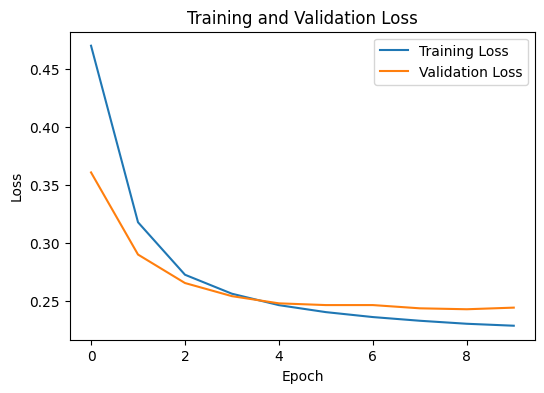

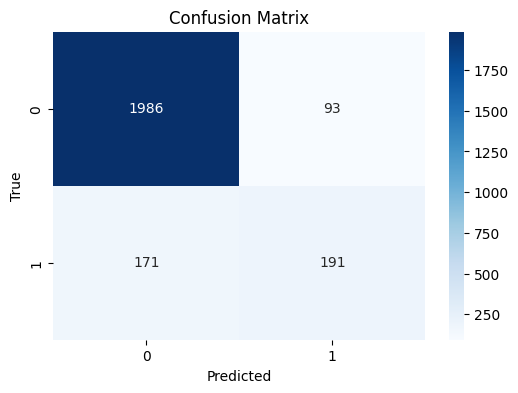

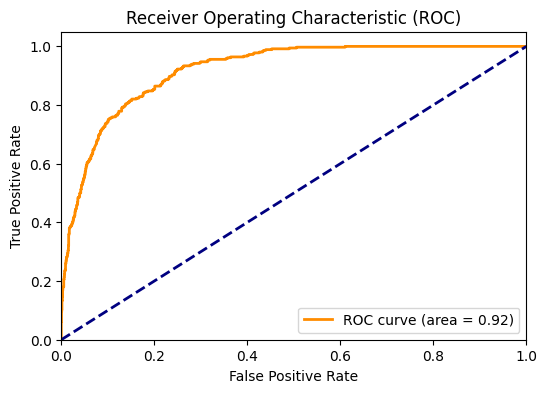


Metrics for Normal Data (Neural Network):
Model                Accuracy   AUC-ROC    Recall    
Neural Network       0.8918     0.9182     0.5276    




In [286]:
# Example usage with normal data
metrics_normal_nn = evaluate_neural_network(X_train, X_test, y_train, y_test)
print("\nMetrics for Normal Data (Neural Network):")
print_metrics_table({'Neural Network': metrics_normal_nn})
print("\n")

## LSTM RNN

In [287]:
def prepare_data_for_lstm(X, y, timesteps=1):
    """
    Reshape data for LSTM input.

    Parameters:
        X (pd.DataFrame): Features.
        y (pd.Series): Target values.
        timesteps (int): Number of timesteps.

    Returns:
        X_lstm (np.array): Reshaped features.
        y (np.array): Target values.
    """
    X = X.values
    y = y.values

    # Reshape data to 3D array (samples, timesteps, features)
    X_lstm = np.reshape(X, (X.shape[0], timesteps, X.shape[1]))

    return X_lstm, y


In [288]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_lstm_model(input_shape):
    """
    Build and compile an LSTM model.

    Parameters:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model: A compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [289]:
def train_and_evaluate_lstm(X_train, y_train, X_test, y_test, epochs=20, batch_size=32):
    """
    Train and evaluate the LSTM model.

    Parameters:
        X_train (np.array): Training features.
        y_train (np.array): Training target values.
        X_test (np.array): Testing features.
        y_test (np.array): Testing target values.
        epochs (int): Number of epochs.
        batch_size (int): Batch size.

    Returns:
        dict: Evaluation metrics (accuracy, AUC-ROC, recall).
        str: Summary of the LSTM model architecture.
    """
    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=0
    )

    # Predict on test set
    y_pred_proba = model.predict(X_test).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)

    # Capture model summary
    buffer = io.StringIO()
    model.summary(print_fn=lambda x: buffer.write(x + '\n'))
    model_summary = buffer.getvalue()

    # Store metrics
    metrics = {
        'Accuracy': accuracy,
        'AUC-ROC': auc_roc,
        'Recall': recall
    }

    return metrics, model_summary, history, model


In [307]:
def print_nn_training_summary_lstm(metrics, model_summary):
    """
    Print the summary of the neural network training, including metrics and model architecture.

    Parameters:
        metrics (dict): Dictionary with evaluation metrics.
        model_summary (str): Summary of the neural network architecture.
    """
    # Print evaluation metrics
    print("Metrics for LSTM Neural Network:")
    print_metrics_table({'LSTM Neural Network': metrics})

    # Print model architecture summary
    print("\nLSTM Neural Network Architecture Summary:")
    print(model_summary)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Metrics and Architecture Summary for LSTM Model:
Metrics for Enhanced Neural Network:
Model                Accuracy   AUC-ROC    Recall    
Enhanced Neural Network 0.8824     0.8862     0.5414    

Neural Network Architecture Summary:
Model: "sequential_24"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 1, 50)               │          20,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 50)                  │               0 │
├─────────────────────────────

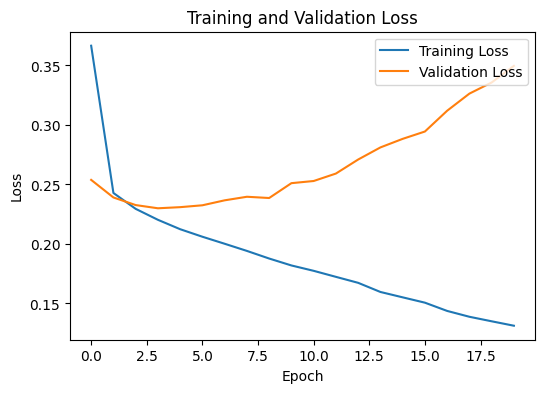

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


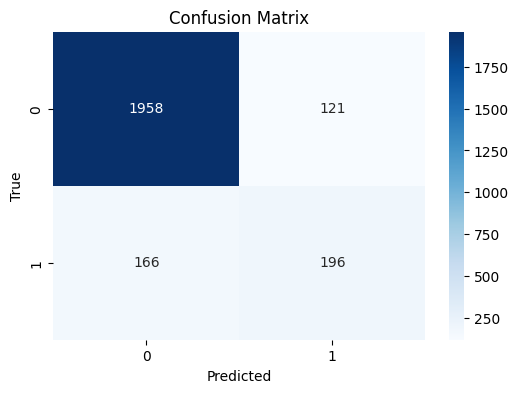

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


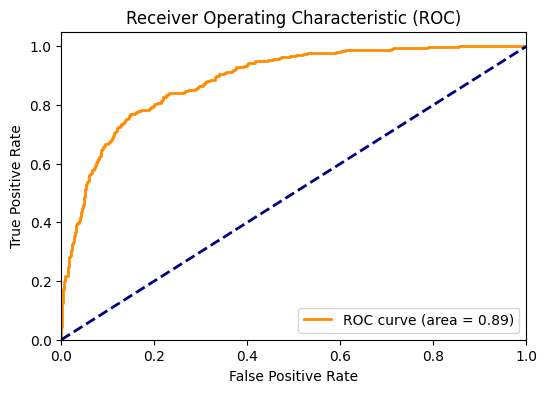

In [290]:
# Example usage for normal data
X_train_lstm, y_train_lstm = prepare_data_for_lstm(X_train, y_train, timesteps=1)
X_test_lstm, y_test_lstm = prepare_data_for_lstm(X_test, y_test, timesteps=1)

metrics_lstm, model_summary_lstm, history_lstm, model_lstm = train_and_evaluate_lstm(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm)

print("Metrics and Architecture Summary for LSTM Model:")
print_nn_training_summary_lstm(metrics_lstm, model_summary_lstm)
plot_validation_loss(history_lstm)
plot_confusion_matrix(y_test_lstm, (model_lstm.predict(X_test_lstm) > 0.5).astype(int), labels=[0, 1])
plot_roc_curve(y_test_lstm, model_lstm.predict(X_test_lstm).ravel())


### Hyperparameter Tuning of ANN

In [291]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.8 MB/s eta 0:00:00


In [292]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from sklearn.model_selection import KFold
import io
import keras_tuner as kt

def build_hypermodel(hp, input_shape):
    """
    Build a hypermodel for Keras Tuner with tunable hyperparameters.

    Parameters:
        hp (kt.HyperParameters): Hyperparameters object.
        input_shape (int): Number of features in the input data.

    Returns:
        model: A compiled Keras model.
    """
    model = Sequential()

    # Tunable number of neurons and layers
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=l2(hp.Float(f'l2_{i}', min_value=1e-4, max_value=1e-2, sampling='log'))
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.3, max_value=0.6, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def tune_hyperparameters(X_train, y_train, n_trials=10):
    """
    Tune hyperparameters using Keras Tuner.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target values.
        n_trials (int): Number of trials for hyperparameter tuning.

    Returns:
        kt.HyperBand: Keras Tuner object.
        dict: Best hyperparameters found.
    """
    def hypermodel_builder(hp):
        return build_hypermodel(hp, X_train.shape[1])

    tuner = kt.Hyperband(
        hypermodel_builder,
        objective='val_accuracy',
        max_epochs=10,
        hyperband_iterations=2,
        directory='my_dir',
        project_name='my_project',
        overwrite=True
    )

    tuner.search(
        X_train, y_train,
        epochs=10,
        validation_split=0.1,
        batch_size=32
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best hyperparameters found:")
    for key, value in best_hps.values.items():
        print(f"{key}: {value}")

    return tuner, best_hps

def evaluate_model_with_best_hps(X_train, X_test, y_train, y_test, tuner):
    """
    Evaluate the model with the best hyperparameters on the given data.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.
        tuner (kt.HyperBand): Keras Tuner object.

    Returns:
        dict: Evaluation metrics (accuracy, AUC-ROC, recall).
        str: Summary of the neural network architecture.
    """
    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]

    # Train the model with the best hyperparameters
    history = best_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)

    # Predict on test set
    y_pred_proba = best_model.predict(X_test).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)

    # Capture model summary
    buffer = io.StringIO()
    best_model.summary(print_fn=lambda x: buffer.write(x + '\n'))
    model_summary = buffer.getvalue()

    # Store metrics
    metrics = {
        'Accuracy': accuracy,
        'AUC-ROC': auc_roc,
        'Recall': recall
    }

    # plot_validation_loss(history)
    plot_confusion_matrix(y_test, y_pred, labels=[0, 1])
    plot_roc_curve(y_test, y_pred_proba)

    return metrics, model_summary

def print_nn_training_summary(metrics, model_summary):
    """
    Print the summary of the neural network training, including metrics and model architecture.

    Parameters:
        metrics (dict): Dictionary with evaluation metrics.
        model_summary (str): Summary of the neural network architecture.
    """
    # Print evaluation metrics
    print("Metrics for Advanced Neural Network with Hyperparameter Tuning:")
    print_metrics_table({'Advanced Neural Network': metrics})

    # Print model architecture summary
    print("\nNeural Network Architecture Summary:")
    print(model_summary)



Trial 60 Complete [00h 00m 16s]
val_accuracy: 0.8792220950126648

Best val_accuracy So Far: 0.9017400145530701
Total elapsed time: 00h 09m 30s
Best hyperparameters found:
num_layers: 4
units_0: 64
l2_0: 0.00892879339836686
dropout_0: 0.5
units_1: 32
l2_1: 0.00021445078424432463
dropout_1: 0.3
learning_rate: 0.0009786475626637578
units_2: 32
l2_2: 0.0017010977253402633
dropout_2: 0.3
units_3: 64
l2_3: 0.00015416325429386038
dropout_3: 0.3
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


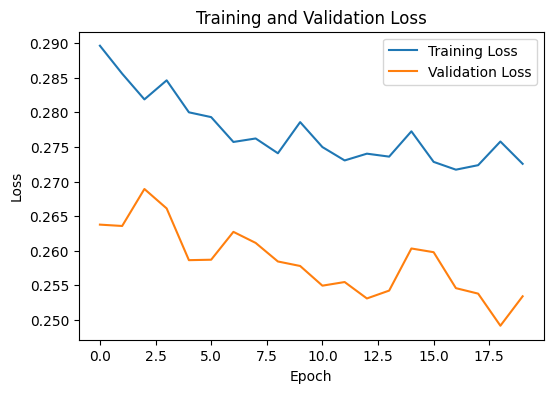

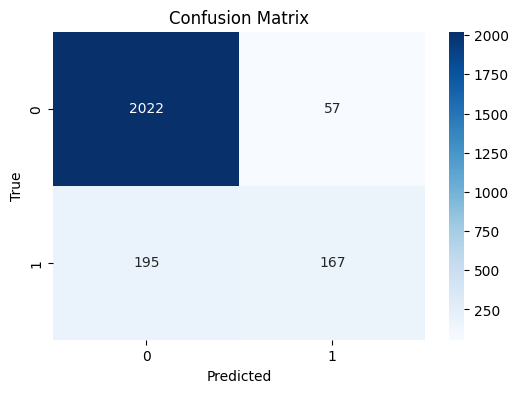

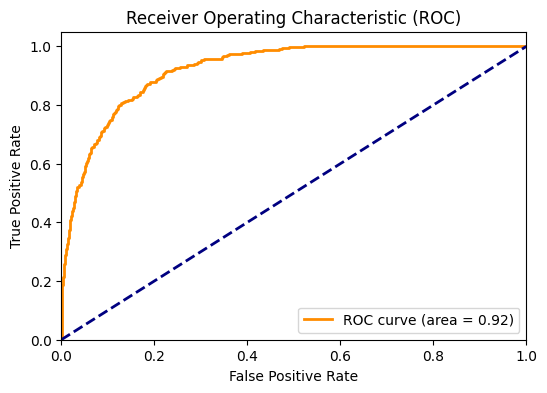


Metrics and Architecture Summary for Normal Data (Advanced Neural Network with Hyperparameter Tuning):
Metrics for Advanced Neural Network with Hyperparameter Tuning:
Model                Accuracy   AUC-ROC    Recall    
Advanced Neural Network 0.8968     0.9233     0.4613    

Neural Network Architecture Summary:
Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           3,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │

In [293]:
# Example usage with normal data
tuner, best_hps = tune_hyperparameters(X_train, y_train, n_trials = 5)
metrics_normal_nn, model_summary_normal_nn = evaluate_model_with_best_hps(X_train, X_test, y_train, y_test, tuner)
print("\nMetrics and Architecture Summary for Normal Data (Advanced Neural Network with Hyperparameter Tuning):")
print_nn_training_summary(metrics_normal_nn, model_summary_normal_nn)


### Train Test Split - Oversampled Data using SMOTE

In [294]:
def split_resampled_data(df_resampled, target_column, test_size=0.2, random_state=42):
    """
    Split the resampled dataframe into training and testing sets.

    Parameters:
        df_resampled (pd.DataFrame): The resampled dataframe.
        target_column (str): The name of the target column.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Seed used by the random number generator.

    Returns:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.
    """
    # Separate features and target variable
    X = df_resampled.drop(columns=[target_column])
    y = df_resampled[target_column]

    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [295]:
# Separate features and target variable
X_r = df_resampled.drop(columns=['Revenue'])
y_r = df_resampled['Revenue']

X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = split_resampled_data(df_resampled, target_column='Revenue')

## Enhanced Neural Network - with Cross Validation Technique

In [296]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from sklearn.model_selection import KFold
import io

def build_advanced_nn_model(input_shape):
    """
    Build an advanced neural network model with deeper architecture and regularization.

    Parameters:
        input_shape (int): The number of features in the input data.

    Returns:
        model: A compiled Keras model.
    """
    model = Sequential()
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.004), input_shape=(input_shape,)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

def evaluate_advanced_neural_network(X, y, n_splits=5):
    """
    Evaluate an advanced neural network model using K-Fold cross-validation.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.
        n_splits (int): Number of folds for cross-validation.

    Returns:
        dict: Average evaluation metrics (accuracy, AUC-ROC, recall) across folds.
        str: Summary of the neural network architecture.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracies = []
    auc_rocs = []
    recalls = []

    model_summary = ""

    first_ind = True

    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Build and train the model
        model = build_advanced_nn_model(X_train_fold.shape[1])

        # Capture model summary
        buffer = io.StringIO()
        model.summary(print_fn=lambda x: buffer.write(x + '\n'))
        model_summary = buffer.getvalue()

        # Train the model
        history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, verbose=0, validation_split=0.1)

        # Predict on test set
        y_pred_proba = model.predict(X_test_fold).ravel()
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_test_fold, y_pred)
        auc_roc = roc_auc_score(y_test_fold, y_pred_proba)
        recall = recall_score(y_test_fold, y_pred)

        accuracies.append(accuracy)
        auc_rocs.append(auc_roc)
        recalls.append(recall)

        if first_ind:
            print("\nPlots for first Cross Validation Fold...\n")
            plot_validation_loss(history)
            plot_confusion_matrix(y_test_fold, y_pred, labels=[0, 1])
            plot_roc_curve(y_test_fold, y_pred_proba)
            first_ind = False
            print("\n")

    # Average metrics across folds
    avg_accuracy = np.mean(accuracies)
    avg_auc_roc = np.mean(auc_rocs)
    avg_recall = np.mean(recalls)

    # Store average metrics
    metrics = {
        'Accuracy': avg_accuracy,
        'AUC-ROC': avg_auc_roc,
        'Recall': avg_recall
    }

    return metrics, model_summary

def print_nn_training_summary(metrics, model_summary):
    """
    Print the summary of the neural network training, including metrics and model architecture.

    Parameters:
        metrics (dict): Dictionary with evaluation metrics.
        model_summary (str): Summary of the neural network architecture.
    """
    # Print evaluation metrics
    print("Metrics for Enhanced Neural Network:")
    print_metrics_table({'Enhanced Neural Network': metrics})

    # Print model architecture summary
    print("\nNeural Network Architecture Summary:")
    print(model_summary)




77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Plots for first Cross Validation Fold...



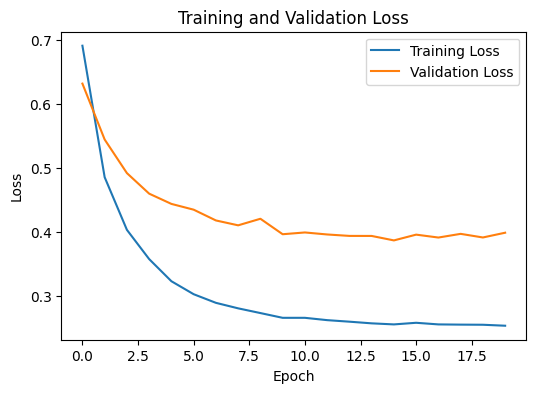

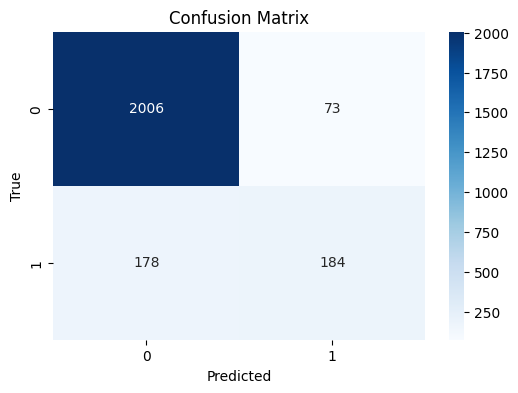

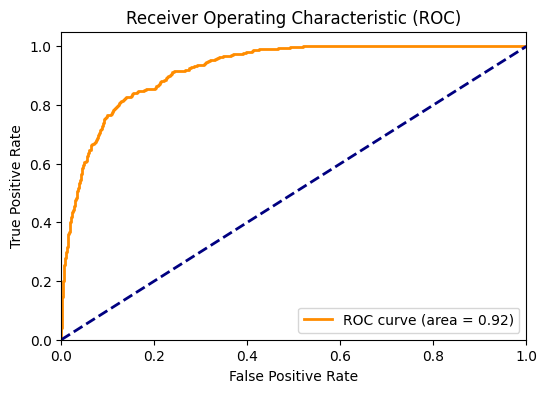

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Metrics and Architecture Summary for Normal Data (Advanced Neural Network):
Metrics for Advanced Neural Network:
Model                Accuracy   AUC-ROC    Recall    
Advanced Neural Network 0.8982     0.9264     0.5739    

Neural Network Architecture Summary:
Model: "sequential_5"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                     │ (None, 128)                 │           6,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)  

In [297]:
# Example usage with normal data
metrics_normal_nn, model_summary_normal_nn = evaluate_advanced_neural_network(X, y, n_splits=5)
print("\nMetrics and Architecture Summary for Normal Data (Enhanced Neural Network):")
print_nn_training_summary(metrics_normal_nn, model_summary_normal_nn)


In [298]:
def evaluate_advanced_neural_network_oversampled(X, y, X_test, y_test, n_splits=5):
    """
    Evaluate an advanced neural network model using K-Fold cross-validation.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.
        n_splits (int): Number of folds for cross-validation.

    Returns:
        dict: Average evaluation metrics (accuracy, AUC-ROC, recall) across folds.
        str: Summary of the neural network architecture.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracies = []
    auc_rocs = []
    recalls = []

    model_summary = ""

    first_ind = True

    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Build and train the model
        model = build_advanced_nn_model(X_train_fold.shape[1])

        # Capture model summary
        buffer = io.StringIO()
        model.summary(print_fn=lambda x: buffer.write(x + '\n'))
        model_summary = buffer.getvalue()

        # Train the model
        history = model.fit(X_train_fold, y_train_fold, epochs=24, batch_size=32, verbose=0, validation_split=0.1)

        # Predict on test set
        y_pred_proba = model.predict(X_test).ravel()
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        recall = recall_score(y_test, y_pred)

        accuracies.append(accuracy)
        auc_rocs.append(auc_roc)
        recalls.append(recall)

        if first_ind:
            print("\nPlots for first Cross Validation Fold...\n")
            plot_validation_loss(history)
            plot_confusion_matrix(y_test, y_pred, labels=[0, 1])
            plot_roc_curve(y_test, y_pred_proba)
            first_ind = False
            print("\n")

    # Average metrics across folds
    avg_accuracy = np.mean(accuracies)
    avg_auc_roc = np.mean(auc_rocs)
    avg_recall = np.mean(recalls)

    # Store average metrics
    metrics = {
        'Accuracy': avg_accuracy,
        'AUC-ROC': avg_auc_roc,
        'Recall': avg_recall
    }

    return metrics, model_summary

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Plots for first Cross Validation Fold...



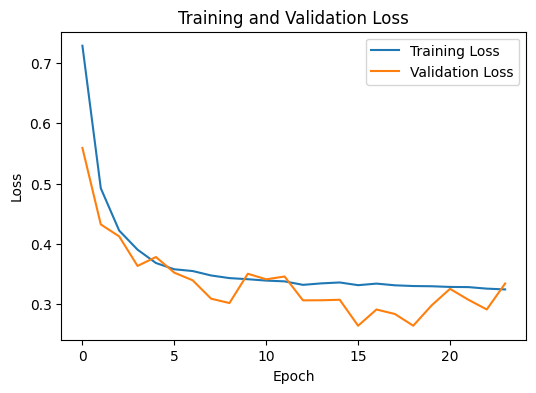

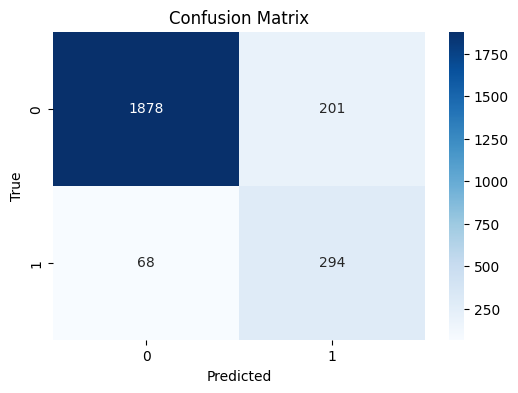

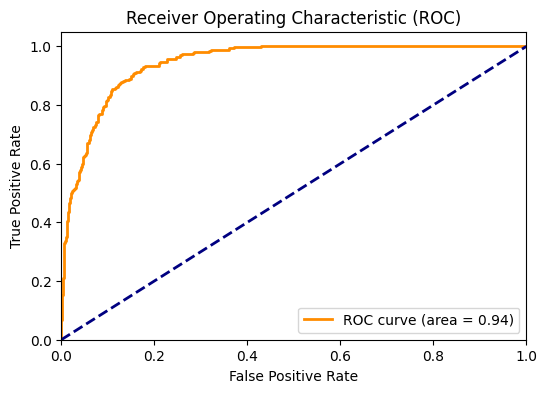

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Metrics and Architecture Summary for Resampled Data (Advanced Neural Network):
Metrics for Advanced Neural Network:
Model                Accuracy   AUC-ROC    Recall    
Advanced Neural Network 0.8828     0.9450     0.8398    

Neural Network Architecture Summary:
Model: "sequential_10"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                     │ (None, 128)                 │           6,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 6

In [299]:
# Example usage with resampled data
metrics_resampled_nn, model_summary_resampled_nn = evaluate_advanced_neural_network_oversampled(X_r, y_r, X_test, y_test, n_splits=5)
print("\nMetrics and Architecture Summary for Resampled Data (Enhanced Neural Network):")
print_nn_training_summary(metrics_resampled_nn, model_summary_resampled_nn)

## Optimized Neural Network

In [301]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from tensorflow.keras.regularizers import l2
import io
import sys

def evaluate_enhanced_neural_network(X_train, X_test, y_train, y_test):
    """
    Train and evaluate an enhanced neural network on the given data.

    Parameters:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target values.
        y_test (pd.Series): Testing target values.

    Returns:
        dict: Dictionary with evaluation metrics (accuracy, AUC-ROC, recall) for the neural network.
        str: Summary of the neural network architecture.
    """
    # Define the enhanced neural network model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.01))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.05))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=16, batch_size=16, verbose=1, validation_split=0.1)

    # Predict on test set
    y_pred_proba = model.predict(X_test).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)

    # Create a string buffer to capture the model summary
    buffer = io.StringIO()
    model.summary(print_fn=lambda x: buffer.write(x + '\n'))
    model_summary = buffer.getvalue()

    # Store metrics
    metrics = {
        'Accuracy': accuracy,
        'AUC-ROC': auc_roc,
        'Recall': recall
    }

    plot_validation_loss(history)
    plot_confusion_matrix(y_test, y_pred, labels=[0, 1])
    plot_roc_curve(y_test, y_pred_proba)

    return metrics, model_summary



In [302]:
def print_nn_training_summary(metrics, model_summary):
    """
    Print the summary of the neural network training, including metrics and model architecture.

    Parameters:
        metrics (dict): Dictionary with evaluation metrics.
        model_summary (str): Summary of the neural network architecture.
    """
    # Print evaluation metrics
    print("Metrics for Optimized Neural Network:")
    print_metrics_table({'Optimized Neural Network': metrics})

    # Print model architecture summary
    print("\nNeural Network Architecture Summary:")
    print(model_summary)

Epoch 1/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8536 - loss: 0.4084 - val_accuracy: 0.8833 - val_loss: 0.2948
Epoch 2/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8967 - loss: 0.2821 - val_accuracy: 0.8915 - val_loss: 0.2847
Epoch 3/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8936 - loss: 0.2703 - val_accuracy: 0.8895 - val_loss: 0.2773
Epoch 4/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9102 - loss: 0.2422 - val_accuracy: 0.8925 - val_loss: 0.2678
Epoch 5/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9066 - loss: 0.2393 - val_accuracy: 0.8925 - val_loss: 0.2601
Epoch 6/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9099 - loss: 0.2285 - val_accuracy: 0.8895 - val_loss: 0.2585
Epoch 7/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9168 - loss: 0.2197 - val_accuracy: 0.9017 - val_loss: 0.2631
Epoch 8/16
550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9159 - loss: 0.2173 - val_accuracy: 0.

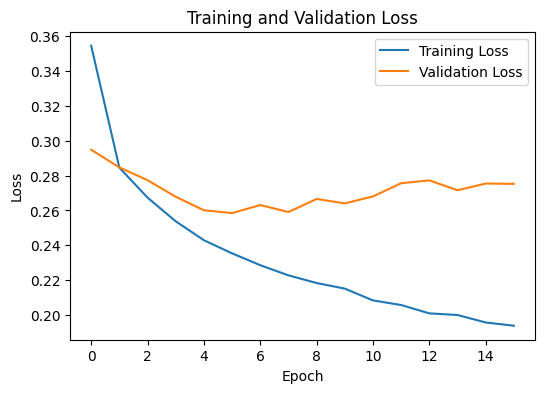

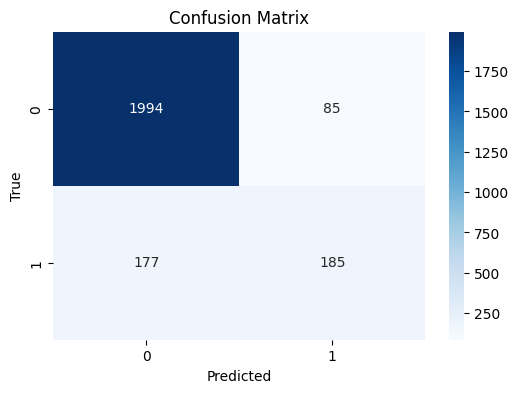

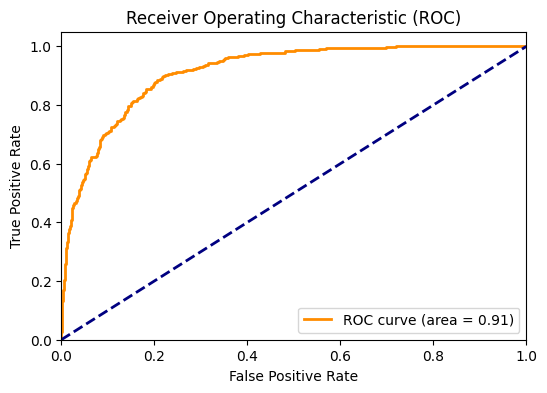


Metrics and Architecture Summary for Normal Data (Enhanced Neural Network):
Metrics for Enhanced Neural Network:
Model                Accuracy   AUC-ROC    Recall    
Enhanced Neural Network 0.8927     0.9136     0.5110    

Neural Network Architecture Summary:
Model: "sequential_11"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                     │ (None, 64)                  │           3,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 32)                  │           2,080 │
├─

In [303]:
# Example usage with normal data
metrics_normal_nn, model_summary_normal_nn = evaluate_enhanced_neural_network(X_train, X_test, y_train, y_test)
print("\nMetrics and Architecture Summary for Normal Data (Optimized Neural Network):")
print_nn_training_summary(metrics_normal_nn, model_summary_normal_nn)

Epoch 1/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7989 - loss: 0.4950 - val_accuracy: 0.8877 - val_loss: 0.3280
Epoch 2/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8832 - loss: 0.3233 - val_accuracy: 0.8975 - val_loss: 0.2971
Epoch 3/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8934 - loss: 0.2913 - val_accuracy: 0.8981 - val_loss: 0.2857
Epoch 4/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9021 - loss: 0.2727 - val_accuracy: 0.8920 - val_loss: 0.2901
Epoch 5/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9017 - loss: 0.2689 - val_accuracy: 0.9005 - val_loss: 0.2613
Epoch 6/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9108 - loss: 0.2477 - val_accuracy: 0.9114 - val_loss: 0.2548
Epoch 7/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9110 - loss: 0.2447 - val_accuracy: 0.9102 - val_loss: 0.2597
Epoch 8/16
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9136 - loss: 0.2355 - val_accuracy: 0.

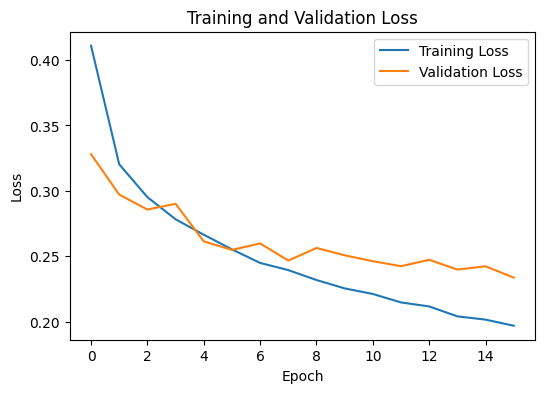

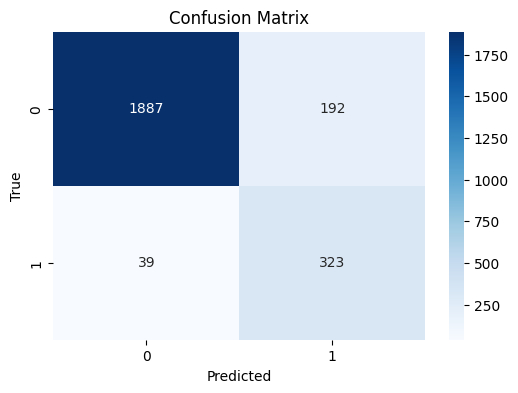

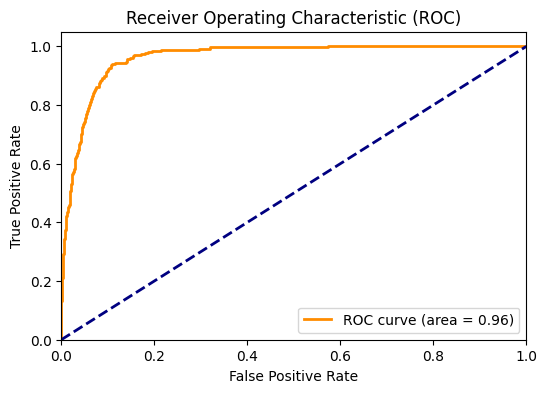


Metrics and Architecture Summary for Resampled Data (Enhanced Neural Network):
Metrics for Enhanced Neural Network:
Model                Accuracy   AUC-ROC    Recall    
Enhanced Neural Network 0.9054     0.9625     0.8923    

Neural Network Architecture Summary:
Model: "sequential_12"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_59 (Dense)                     │ (None, 64)                  │           3,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 32)                  │           2,080 │

In [304]:
# Evaluate with resampled data
metrics_resampled_nn, model_summary_resampled_nn = evaluate_enhanced_neural_network(X_train_resampled, X_test, y_train_resampled, y_test)
print("\nMetrics and Architecture Summary for Resampled Data (Optimized Neural Network):")
print_nn_training_summary(metrics_resampled_nn, model_summary_resampled_nn)

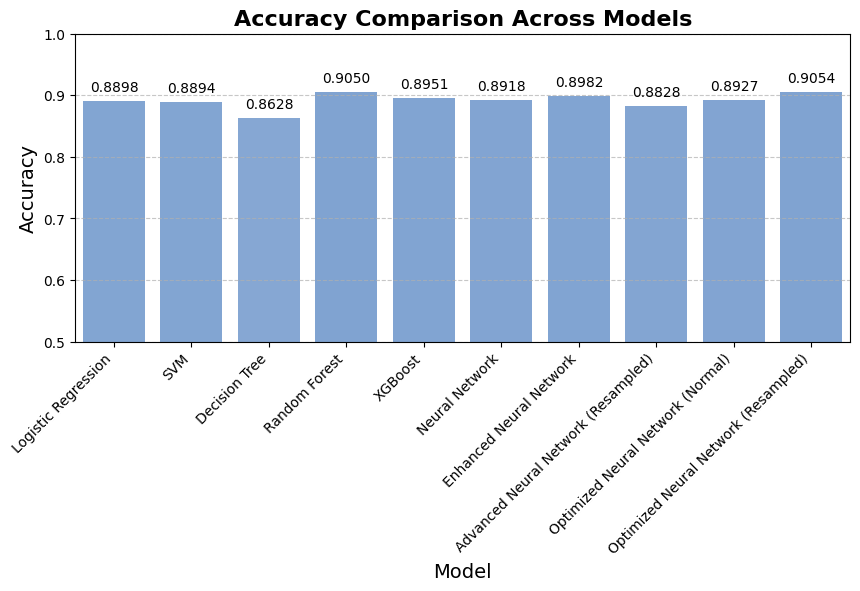

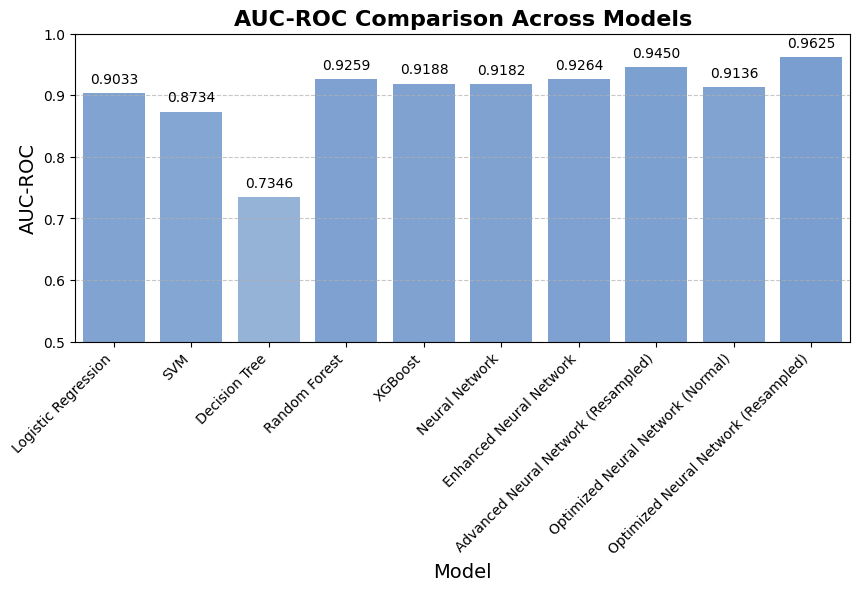

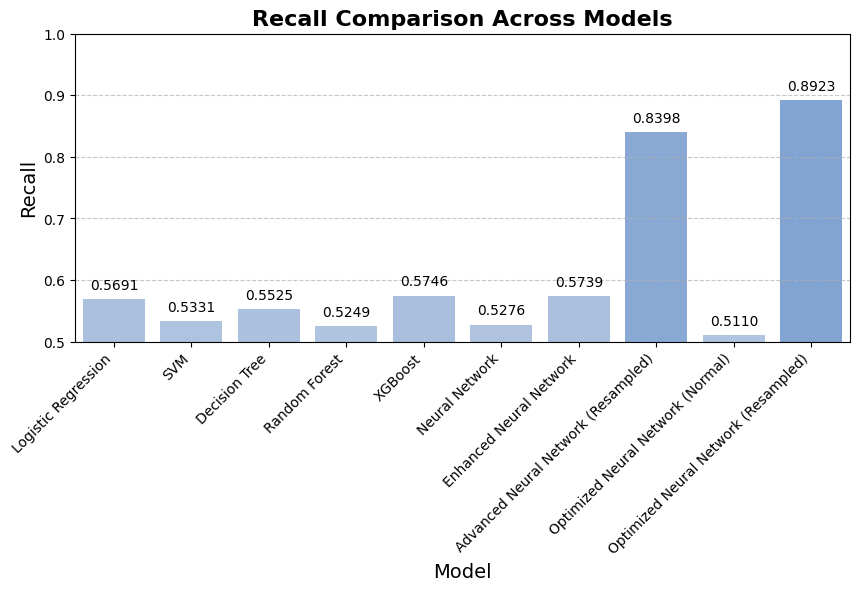

In [325]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data
models = ['Logistic Regression', 'SVM', 'Decision Tree',
          'Random Forest', 'XGBoost',
          'Neural Network',
          'Enhanced Neural Network',
          'Advanced Neural Network (Resampled)',
          'Optimized Neural Network (Normal)',
          'Optimized Neural Network (Resampled)']

accuracy = [0.8898, 0.8894, 0.8628, 0.9050, 0.8951, 0.8918, 0.8982, 0.8828, 0.8927, 0.9054]
auc_roc = [0.9033, 0.8734, 0.7346, 0.9259, 0.9188, 0.9182, 0.9264, 0.9450, 0.9136, 0.9625]
recall = [0.5691, 0.5331, 0.5525, 0.5249, 0.5746, 0.5276, 0.5739, 0.8398, 0.5110, 0.8923]

# Creating a DataFrame for better handling
data = {
    'Model': models,
    'Accuracy': accuracy,
    'AUC-ROC': auc_roc,
    'Recall': recall
}

df = pd.DataFrame(data)

# Custom color palette based on performance
cmap = sns.light_palette("#69d", as_cmap=True)

# Plotting
metrics = ['Accuracy', 'AUC-ROC', 'Recall']

for metric in metrics:
    plt.figure(figsize=(10, 4))
    bar = sns.barplot(x='Model', y=metric, data=df, palette=cmap(df[metric]))

    # Add annotations on the bars
    for p in bar.patches:
        bar.annotate(format(p.get_height(), '.4f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 10),
                     textcoords = 'offset points')

    plt.xticks(rotation=45, ha="right")
    plt.title(f'{metric} Comparison Across Models', fontsize=16, weight='bold')
    plt.ylabel(metric, fontsize=14)
    plt.xlabel('Model', fontsize=14)
    plt.ylim(0.5, 1)  # Adjust the y-axis to highlight differences
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()


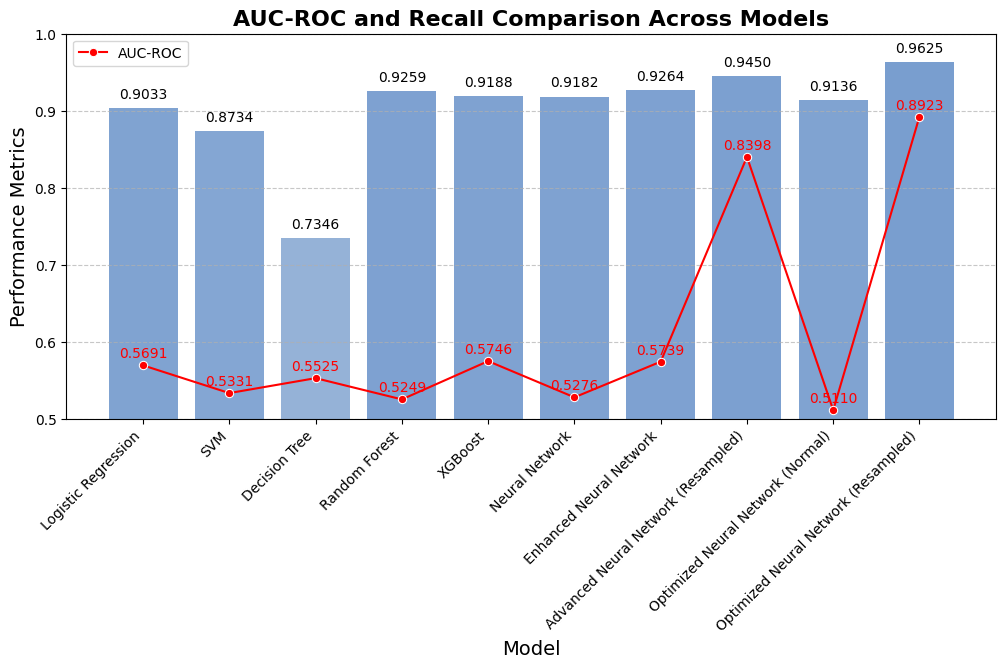

In [327]:
# Combining Bars and Line Markers
plt.figure(figsize=(12, 5))

bar = sns.barplot(x='Model', y='AUC-ROC', data=df, palette=cmap(df['AUC-ROC']))
line = sns.lineplot(x='Model', y='Recall', data=df, color='red', marker='o', label='AUC-ROC')

# Add annotations on the bars
for p in bar.patches:
    bar.annotate(format(p.get_height(), '.4f'),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'center',
                 xytext = (0, 10),
                 textcoords = 'offset points')

# Line markers for AUC-ROC
for i, point in enumerate(df['Recall']):
    plt.text(i, point + 0.01, f'{point:.4f}', ha='center', color='red')

plt.xticks(rotation=45, ha="right")
plt.title('AUC-ROC and Recall Comparison Across Models', fontsize=16, weight='bold')
plt.ylabel('Performance Metrics', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.ylim(0.5, 1)  # Adjust y-axis
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


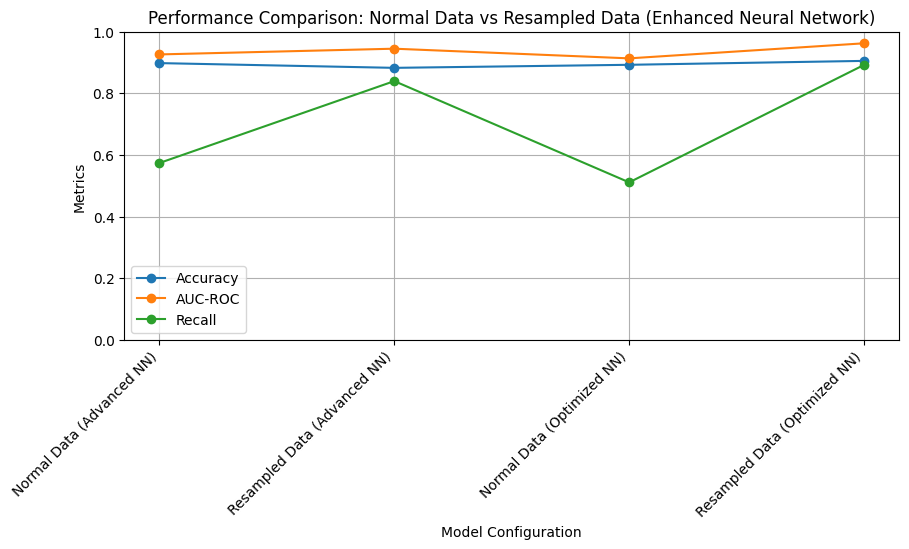

In [312]:
# Data for Enhanced Neural Network
models = ['Normal Data (Advanced NN)', 'Resampled Data (Advanced NN)',
          'Normal Data (Optimized NN)', 'Resampled Data (Optimized NN)']

accuracy = [0.8982, 0.8828, 0.8927, 0.9054]
auc_roc = [0.9264, 0.9450, 0.9136, 0.9625]
recall = [0.5739, 0.8398, 0.5110, 0.8923]

# Creating a DataFrame
data_resampled = {
    'Model': models,
    'Accuracy': accuracy,
    'AUC-ROC': auc_roc,
    'Recall': recall
}

df_resampled = pd.DataFrame(data_resampled)

# Plotting
plt.figure(figsize=(10, 4))

plt.plot(df_resampled['Model'], df_resampled['Accuracy'], marker='o', label='Accuracy')
plt.plot(df_resampled['Model'], df_resampled['AUC-ROC'], marker='o', label='AUC-ROC')
plt.plot(df_resampled['Model'], df_resampled['Recall'], marker='o', label='Recall')

plt.title('Performance Comparison: Normal Data vs Resampled Data (Enhanced Neural Network)')
plt.xlabel('Model Configuration')
plt.ylabel('Metrics')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(True)
plt.show()
